## **Neuro-fuzzy Computing Project**

Armpounioti Maria - Eleni  03183

Patakioutis Sofoklis       03310

## **Connect to Google Drive to have access to resources**

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Functions for Dataset**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

def load_dataset(filepath, columns):
    return pd.read_csv(filepath, usecols=columns)

def save_dataset(dataset, filepath):
    dataset.to_csv(filepath, index=False)

def dataset_split_train_test(dataset, test_size, stratify):
    return train_test_split(dataset, test_size=test_size, stratify=stratify, random_state=42)

def dataset_split_into_categories(dataset):
    categories = dataset['category_level_1'].unique()

    subset_per_category = {}
    for category in categories:
        subset_per_category[category] = dataset[dataset['category_level_1'] == category]

    return subset_per_category

def visualize_dataset(dataset, column, main_catergory):

    category_counts = dataset[column].value_counts()

    plt.figure(figsize=(10, 6))
    ax = category_counts.plot(kind='bar')
    plt.title('Number of Articles per ' + column)
    plt.xlabel(main_catergory)
    plt.ylabel('Number of Articles')
    plt.xticks(rotation=45, ha='right')

    for i in ax.containers:
        ax.bar_label(i, label_type='edge')

    plt.show()

def visualize_article_length_distribution(dataset):
    article_length_words = dataset['content'].apply(lambda x: len(x.split()))
    median = article_length_words.median()

    plt.figure(figsize=(10, 6))
    plt.hist(article_length_words, bins=30, edgecolor='black')
    plt.title(f'Distribution of Article Lengths |  Median: {median}')
    plt.xlabel('Article Length (Words)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## **Functions for Data Preprocessing**

In [4]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()

    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = nltk.word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

def vectorize_data(X_text, tokenizer):
    return tokenizer.texts_to_sequences(X_text)

def add_padding(sequences, max_len):
    return pad_sequences(sequences, maxlen=max_len, padding='post')

def encode_target_outputs(encoder, y_labels_encoded, num_classes):
    return to_categorical(y_labels_encoded, num_classes=num_classes)

def dataset_split_train_validate(X_sequences, y_targets, validation_size, stratify_category):
    return train_test_split(X_sequences, y_targets, test_size=validation_size, stratify=stratify_category, random_state=42)

def prepare_dataset_for_model(dataset, max_words=100000, category_level='', num_classes=0, input_len=-1, tokenizer=None, encoder=None):
    X_text = dataset['title'].astype(str) + ' ' + dataset['content'].astype(str)
    X_text = X_text.apply(preprocess_text)
    X_text =  dataset["date"].astype(str) + ' ' + dataset["source"].astype(str) + ' ' + X_text

    if (input_len == -1):
        article_length_words = dataset['content'].apply(lambda x: len(x.split()))
        input_len = int(article_length_words.median())

    if (tokenizer is None):
        tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
        tokenizer.fit_on_texts(X_text)

    if (encoder is None):
        encoder = LabelEncoder()
        encoder.fit(dataset[category_level])

    X_sequences = vectorize_data(X_text, tokenizer)
    X_sequences = add_padding(X_sequences, input_len)

    y_labels_encoded = encoder.transform(dataset[category_level])
    y_targets = encode_target_outputs(encoder, y_labels_encoded, num_classes)

    return tokenizer, encoder, input_len, X_sequences, y_targets

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Functions for Neural Network Models**

In [5]:
import os
import json
import pickle
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt

def model_load(directory):
    model = load_model(f'{directory}/model.h5')

    with open(f'{directory}/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    with open(f'{directory}/config.json', 'r') as config_file:
        config = json.load(config_file)

    with open(f'{directory}/label_encoder.pickle', 'rb') as handle:
        encoder = pickle.load(handle)

    return model, tokenizer, encoder, config

def model_save(directory, model, tokenizer, encoder, config):
    if not os.path.exists(directory):
        os.makedirs(directory)

    model.save(f'{directory}/model.h5')

    with open(f'{directory}/tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{directory}/label_encoder.pickle', 'wb') as handle:
        pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'{directory}/config.json', 'w') as config_file:
        json.dump(config, config_file)

def plot_training_history(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training / Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
    plt.title('Training / Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.legend()

def model_train(model, X_sequences, y_targets, validation_size, class_weights=None, batch_size=100, epochs=10, callbacks=[]):

    X_train, X_val, y_train, y_val = dataset_split_train_validate(X_sequences, y_targets, validation_size, stratify_category=y_targets)

    if (class_weights is None):
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val,  y_val), callbacks=callbacks, shuffle=True)
    else:
        history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val,  y_val), callbacks=callbacks, class_weight=class_weights, shuffle=True)

    plot_training_history(history)

def model_evaluate_single_level(model, X_test, y_test, name):

    loss, accuracy = model.evaluate(X_test, y_test)

    print(f'------------ Model {name} | Performance on Testing Set ------------')
    print(f'                   Loss:     {loss:.4f}                            ')
    print(f'                   Accuracy: {accuracy:.4f}                        ')
    print('--------------------------------------------------------------------')

In [6]:
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 26.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
import numpy as np
import spacy

def create_embedding(word_index):
    nlp = spacy.load('en_core_web_md')

    text_embedding = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        text_embedding[i] = nlp(word).vector

    return text_embedding

## **Dataset manipulation / Split in train and test set / Breakdown into smaller sub-sets for level 2 classification**
(not necessary to run every time)

In [ ]:
dataset = load_dataset('/content/gdrive/MyDrive/Project Neural Networks/Datasets/news-classification.csv', columns=["date","source","title","content","category_level_1","category_level_2"])

train_dataset, test_dataset = dataset_split_train_test(dataset, 0.1, dataset['category_level_1'])

save_dataset(train_dataset, '/content/gdrive/MyDrive/Project Neural Networks/Datasets/training/main_classifier.csv')
save_dataset(test_dataset, '/content/gdrive/MyDrive/Project Neural Networks/Datasets/testing/main_classifier.csv')


In [ ]:
train_subdatasets = dataset_split_into_categories(train_dataset)
test_subdatasets = dataset_split_into_categories(test_dataset)

for category in train_subdatasets:
    train_subdataset = train_subdatasets[category]
    test_subdataset = test_subdatasets[category]

    save_dataset(train_subdataset,  f'/content/gdrive/MyDrive/Project Neural Networks/Datasets/training/{category}_train.csv')
    save_dataset(test_subdataset, f'/content/gdrive/MyDrive/Project Neural Networks/Datasets/testing/{category}_test.csv')

## **Visualize Dataset / Obtain valuable info**
(not necessary to run every time)

In [ ]:
visualize_dataset(dataset, "category_level_1", "Category level 1")

In [ ]:
main_categories = dataset["category_level_1"].unique()

for category in main_categories:
    sub_dataset = dataset[ dataset['category_level_1'] == category ]
    visualize_dataset(sub_dataset, "category_level_2", category)

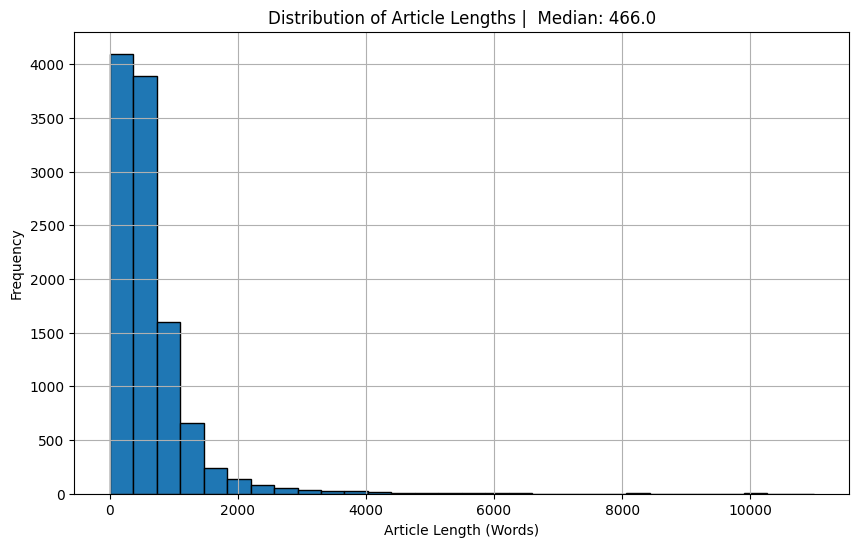

In [ ]:
dataset = load_dataset('/content/gdrive/MyDrive/Project Neural Networks/Datasets/news-classification.csv', columns=["date","source","title","content","category_level_1","category_level_2"])

visualize_article_length_distribution(dataset)

## **Separate Model Trainings and Testings**

### **Category Level 1 Classifier**

##### **Load train dataset for level 1 classifier**



In [3]:
train_dataset = load_dataset('/content/gdrive/MyDrive/Project Neural Networks/Datasets/training/main_classifier.csv', columns=["date","source","title","content","category_level_1","category_level_2"] )

##### **Preprocess dataset and create embedding weights**

In [8]:
tokenizer, encoder, input_len, X_sequences, y_targets = prepare_dataset_for_model(train_dataset, max_words=100000, category_level='category_level_1', num_classes=17)
text_embedding = create_embedding(tokenizer.word_index)

##### **Model definition and train**

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │      24,094,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_10                 │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_11                 │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,094,800 (91.91 MB)

 Trainable params: 24,094,800 (91.91 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.1175 - loss: 3.0627 - val_accuracy: 0.5331 - val_loss: 1.7936
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - accuracy: 0.4369 - loss: 1.7935 - val_accuracy: 0.6073 - val_loss: 1.3571
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.5745 - loss: 1.3459 - val_accuracy: 0.6531 - val_loss: 1.2056
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.6293 - loss: 1.1627 - val_accuracy: 0.6755 - val_loss: 1.0617
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.6661 - loss: 1.0225 - val_accuracy: 0.6907 - val_loss: 0.9919
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.7043 - loss: 0.9228 - val_accuracy: 0.7121 - val_loss: 0.9340
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.7268 - loss: 0.8243 - val_accuracy: 0.7325 - val_loss: 0.8874
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - accuracy: 0.7463 - loss: 0.76

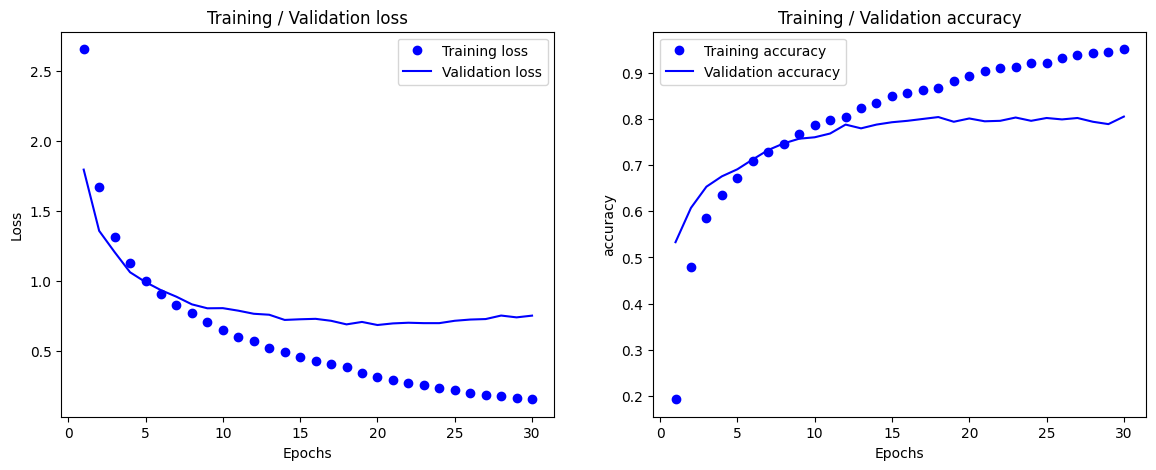

In [21]:
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_targets.argmax(axis=1)), y=y_targets.argmax(axis=1))
class_weights = dict(enumerate(class_weights))

model = keras.models.Sequential()

model.add(keras.layers.Embedding(input_dim    = text_embedding.shape[0],
                                 output_dim   = text_embedding.shape[1],
                                 weights      = [text_embedding],
                                 trainable    = True
                                 ))

model.add(keras.layers.SpatialDropout1D(0.1))

model.add(keras.layers.Bidirectional(keras.layers.LSTM(256, return_sequences=True)))

model.add(keras.layers.SpatialDropout1D(0.59))

model.add(keras.layers.GlobalMaxPooling1D())

model.add(keras.layers.Dense(17, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

model_train(model, X_sequences, y_targets, 0.1, class_weights, batch_size=120, epochs=100, callbacks=[early_stopping])

##### **Save model**

In [ ]:
model_save(f'/content/gdrive/MyDrive/Project Neural Networks/Models/main_classifier', model, tokenizer, encoder, {'params': {}, 'input_len': input_len})

##### **Load and preprocess testing dataset for level 1 classifier**

In [10]:
test_set = load_dataset('/content/gdrive/MyDrive/Project Neural Networks/Datasets/testing/main_classifier.csv', columns=["date","source","title","content","category_level_1","category_level_2"] )

tokenizer, encoder, median, X_test, y_test = prepare_dataset_for_model(test_set, max_words=100000, category_level='category_level_1', num_classes=17, tokenizer=tokenizer, encoder=encoder, input_len=input_len)

##### **Test the level 1 classifier using the testing dataset**

In [22]:
model_evaluate_single_level(model, X_test, y_test, 'main classifier')

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7777 - loss: 0.7808
------------ Model main classifier | Performance on Testing Set ------------
                   Loss:     0.7799                            
                   Accuracy: 0.7711                        
--------------------------------------------------------------------


### **Category Level 2 Classifiers**

#### **Training Params**

In [ ]:
training_params = {
    'science and technology':                     { 'lstm_size':  80 , 'batch_size': 12 , 'spatial_drop': 0.45 },
    'sport':                                      { 'lstm_size': 100 , 'batch_size': 12 , 'spatial_drop': 0.6  },
    'health':                                     { 'lstm_size': 100 , 'batch_size': 10 , 'spatial_drop': 0.59 },
    'society':                                    { 'lstm_size': 100 , 'batch_size': 12 , 'spatial_drop': 0.58 },
    'environment':                                { 'lstm_size': 100 , 'batch_size': 10 , 'spatial_drop': 0.5  },
    'education':                                  { 'lstm_size': 100 , 'batch_size': 10 , 'spatial_drop': 0.3  },
    'religion and belief':                        { 'lstm_size': 100 , 'batch_size': 12 , 'spatial_drop': 0.55 },
    'labour':                                     { 'lstm_size':  60 , 'batch_size': 12 , 'spatial_drop': 0.3  },
    'crime, law and justice':                     { 'lstm_size':  90 , 'batch_size': 10 , 'spatial_drop': 0.57 },
    'conflict, war and peace':                    { 'lstm_size': 100 , 'batch_size': 12 , 'spatial_drop': 0.6  },
    'politics':                                   { 'lstm_size': 100 , 'batch_size': 11 , 'spatial_drop': 0.48 },
    'human interest':                             { 'lstm_size': 100 , 'batch_size': 10 , 'spatial_drop': 0.59 },
    'weather':                                    { 'lstm_size': 100 , 'batch_size': 10 , 'spatial_drop': 0.55 },
    'arts, culture, entertainment and media':     { 'lstm_size':  90 , 'batch_size':  7 , 'spatial_drop': 0.55 },
    'disaster, accident and emergency incident':  { 'lstm_size': 120 , 'batch_size':  8 , 'spatial_drop': 0.6  },
    'lifestyle and leisure':                      { 'lstm_size': 120 , 'batch_size': 12 , 'spatial_drop': 0.55 },
    'economy, business and finance':              { 'lstm_size': 120 , 'batch_size': 12 , 'spatial_drop': 0.55 }
}

#### **Function for model definiton and train**

In [ ]:
import tensorflow.keras as keras
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

def build_train_subclassifier(text_embedding,  X_train, y_train, lstm_size=0, num_of_classes=0, batch_size=0, spatial_dropout=0):
    model = keras.models.Sequential()

    model.add(keras.layers.Embedding(input_dim    = text_embedding.shape[0],
                                    output_dim   = text_embedding.shape[1],
                                    weights      = [text_embedding],
                                    trainable    = True
                                    ))

    model.add(keras.layers.Bidirectional(keras.layers.LSTM(lstm_size, return_sequences=True)))
    model.add(keras.layers.SpatialDropout1D(spatial_dropout))

    model.add(keras.layers.GlobalMaxPooling1D())

    model.add(keras.layers.Dense(num_of_classes, activation='softmax'))

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'], )
    print(model.summary())

    model_train(model, X_train, y_train, 0.1, batch_size=batch_size, epochs=35, callbacks=[early_stopping])

    return model

#### **Train all sub classifiers at once**

In [ ]:
for category, params in training_params.items():
    sub_dataset = load_dataset(f'/content/gdrive/MyDrive/Project Neural Networks/Datasets/training/{category}_train.csv', columns=["date","source","title","content","category_level_1","category_level_2"] )
    sub_categories_num = len(sub_dataset["category_level_2"].unique())

    sub_tokenizer, sub_encoder, sub_input_len, sub_X_sequences, sub_y_targets = prepare_dataset_for_model(sub_dataset, max_words=100000, category_level='category_level_2', num_classes=sub_categories_num)

    sub_text_embedding = create_embedding(sub_tokenizer.word_index)

    print(f'Training model for {category}')

    sub_classifier = build_train_subclassifier(sub_text_embedding, sub_X_sequences, sub_y_targets, lstm_size=params['lstm_size'], num_of_classes=sub_categories_num, batch_size=params['batch_size'], spatial_dropout=params['spatial_drop'])

    model_save(f'/content/gdrive/MyDrive/Project Neural Networks/Models/{category}', sub_classifier, sub_tokenizer, sub_encoder, {'params': params, 'input_len': sub_input_len})

NameError: name 'load_dataset' is not defined

#### **Test all sub classifiers at once**

In [ ]:
for category in training_params.keys():

    print(f'Testing model for {category}')

    # load subclassifier
    sub_classifier, sub_tokenizer, sub_encoder, sub_config = model_load(f'/content/gdrive/MyDrive/Project Neural Networks/Models/{category}')
    sub_input_len = sub_config['input_len']

    # load and preprocess testing set
    sub_test_set = load_dataset(f'/content/gdrive/MyDrive/Project Neural Networks/Datasets/testing/{category}_test.csv', columns=["date","source","title","content","category_level_1","category_level_2"] )
    sub_categories_num = len(sub_test_set["category_level_2"].unique())
    sub_tokenizer, sub_encoder, sub_input_len, sub_X_test, sub_y_test = prepare_dataset_for_model(sub_test_set, max_words=100000, category_level='category_level_2', num_classes=sub_categories_num, tokenizer=sub_tokenizer, encoder=sub_encoder, input_len=sub_input_len)

    # evaluate
    model_evaluate_single_level(sub_classifier, sub_X_test, sub_y_test, name=category)


#### **Train / Test single subclassifier (for trials)**
Put the level 1 category you want into the variable 'category' and run the corresponding cells to load the dataset, preprocess and create the embedding, train and test the level 2 classifier

##### **Load train dataset for subclassifier**

In [ ]:
category = 'science and technology'

sub_dataset = load_dataset(f'/content/gdrive/MyDrive/Project Neural Networks/Datasets/training/{category}_train.csv', columns=["date","source","title","content","category_level_1","category_level_2"] )
sub_categories_num = len(sub_dataset["category_level_2"].unique())

##### **Preprocess dataset and create embedding weights**

In [ ]:
sub_tokenizer, sub_encoder, sub_input_len, sub_X_sequences, sub_y_targets = prepare_dataset_for_model(sub_dataset, max_words=100000, category_level='category_level_2', num_classes=sub_categories_num)

sub_text_embedding = create_embedding(sub_tokenizer.word_index)

##### **Execute model compilation and training with desired parameters**

In [ ]:
print(f'Training model for {category}')
sub_classifier = build_train_subclassifier(sub_text_embedding, sub_X_sequences, sub_y_targets, lstm_size=80, num_of_classes=sub_categories_num, batch_size=12, spatial_dropout=0.55)

##### **Save subclassifier model**

In [ ]:
model_save(f'/content/gdrive/MyDrive/Project Neural Networks/Models/{category}', sub_classifier, sub_tokenizer, sub_encoder, {'params': training_params[category], 'input_len': sub_input_len})

##### **Load subclassifier model**

In [ ]:
sub_classifier, sub_tokenizer, sub_encoder, sub_config = model_load(f'/content/gdrive/MyDrive/Project Neural Networks/Models/{category}')
print(sub_classifier.summary())
sub_input_len = sub_config['input_len']

##### **Load and preprocess testing dataset for subclassifier**

In [ ]:
sub_test_set = load_dataset(f'/content/gdrive/MyDrive/Project Neural Networks/Datasets/testing/{category}_test.csv', columns=["date","source","title","content","category_level_1","category_level_2"] )

sub_tokenizer, sub_encoder, sub_input_len, sub_X_test, sub_y_test = prepare_dataset_for_model(sub_test_set, max_words=100000, category_level='category_level_2', num_classes=sub_categories_num, tokenizer=sub_tokenizer, encoder=sub_encoder, input_len=sub_input_len)

##### **Test the subclassifier using the testing dataset**

In [ ]:
model_evaluate_single_level(sub_classifier, sub_X_test, sub_y_test, name=category)

## **Model levels connection / Testing both levels**

#### **Load the whole model**

In [ ]:
complete_model = {}
subclassifiers = {}

# load the level 1 model
classifier, tokenizer, encoder, config = model_load(f'/content/gdrive/MyDrive/Project Neural Networks/Models/main_classifier')

level_1_categories = encoder.classes_

complete_model['main_classifier'] = {
    'model': classifier,
    'tokenizer': tokenizer,
    'encoder': encoder,
    'input_len': config['input_len'],
    'categories': encoder.classes_
}

# load the level 2 models
complete_model['subclassifiers'] = subclassifiers

for category in level_1_categories:
    sub_classifier, sub_tokenizer, sub_encoder, sub_config = model_load(f'/content/gdrive/MyDrive/Project Neural Networks/Models/{category}')

    complete_model['subclassifiers'][f'{category}'] = {
        'model': sub_classifier,
        'tokenizer': sub_tokenizer,
        'encoder': sub_encoder,
        'input_len': sub_config['input_len'],
        'categories': sub_encoder.classes_
    }

#### **Load testing set**

In [ ]:
test_set = load_dataset('/content/gdrive/MyDrive/Project Neural Networks/Datasets/testing/main_classifier.csv', columns=["date","source","title","content","category_level_1","category_level_2"] )

#### **Measure test accuracy and inference time**

In [ ]:
import time

correct_predictions = 0
total_samples = len(test_set)
total_inference_time = 0

for index, row in test_set.iterrows():

    print(f'------------- Iteration {index} ----------------')

    sample = pd.DataFrame([row])
    # preprocess for level 1 input
    _ , _ , _ , X_test_sample_1, y_test_sample_1 = prepare_dataset_for_model(sample, max_words=100000, category_level='category_level_1', num_classes=17,
                                                                             tokenizer=complete_model['main_classifier']['tokenizer'],
                                                                             encoder=complete_model['main_classifier']['encoder'],
                                                                             input_len=complete_model['main_classifier']['input_len'])

    start_time = time.time()
    level_1_predictions = complete_model['main_classifier']['model'].predict(X_test_sample_1)
    end_time = time.time()

    total_inference_time += (end_time - start_time)

    predicted_level_1_category_index = np.argmax(level_1_predictions)
    true_level_1_category_index = np.argmax(y_test_sample_1)

    predicted_level_1_category = complete_model['main_classifier']['encoder'].inverse_transform([predicted_level_1_category_index])[0]

    # if level 1 predicted correctly
    if predicted_level_1_category_index == true_level_1_category_index:

        # preprocess for level 2 input
        num_of_subclasses = len(complete_model['subclassifiers'][f'{predicted_level_1_category}']['categories'])
        _ , _ , _ , X_test_sample_2, y_test_sample_2 = prepare_dataset_for_model(sample, max_words=100000, category_level='category_level_2', num_classes=num_of_subclasses,
                                                                                 tokenizer=complete_model['subclassifiers'][f'{predicted_level_1_category}']['tokenizer'],
                                                                                 encoder=complete_model['subclassifiers'][f'{predicted_level_1_category}']['encoder'],
                                                                                 input_len=complete_model['subclassifiers'][f'{predicted_level_1_category}']['input_len'])

        start_time = time.time()
        level_2_predictions = complete_model['subclassifiers'][f'{predicted_level_1_category}']['model'].predict(X_test_sample_2)
        end_time = time.time()

        total_inference_time += (end_time - start_time)

        predicted_level_2_category_index = np.argmax(level_2_predictions)
        true_level_2_category_index = np.argmax(y_test_sample_2)

        if predicted_level_2_category_index == true_level_2_category_index:
                correct_predictions += 1

accuracy = correct_predictions / total_samples
average_inference_time = total_inference_time / total_samples

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Total Inference Time: {total_inference_time:.4f} seconds")
print(f"Average Inference Time: {average_inference_time:.4f} seconds")


------------- Iteration 0 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
------------- Iteration 1 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
------------- Iteration 2 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
------------- Iteration 3 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
------------- Iteration 4 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
------------- Iteration 5 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
------------- Iteration 6 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
------------- Iteration 7 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
------------- Iteration 8 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
------------- Iteration 9 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
------------- Iteration 10 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
------------- Iteration 11 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
------------- Iteration 12 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
------------- Iteration 13 ----------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/ste